### Analytical model vs Booskim2 comparison script

In [78]:
import numpy as np
import pandas as pd
import os 
import sys
import itertools
import time
import matplotlib.pyplot as plt

In [172]:
# Import plotting functions from plotting_utils
import importlib
import plotting_utils

# Reload the module to get latest changes
importlib.reload(plotting_utils)

from plotting_utils import (
    plot_latency_breakdown_new_3_bars,
    plot_latency_breakdown_with_error,
    plot_latency_breakdown_with_trend,
    plot_latency_breakdown_with_error_from_two_files_with_broken_axis
)


In [2]:
"""
Concatenate CSV files from different experiments into two master files.
Skips files that only contain headers (no data rows).
"""

# Define the directory
data_dir = '../data/light_noc_comp'

# Define the file prefixes in order
prefixes = ['p1', 'p2', 'p3_1', 'p3_2', 'p3_3', 'p3_4',
            'p4_1', 'p4_2', 'p4_3', 'p4_4',
            'p5_1', 'p5_2', 'p5_3', 'p5_4', 'p5_5', 'p5_6', 'p5_7',
            'p6', 'p7']

# File types to concatenate
file_types = [
    ('latency_energy_results', 'Latency_energy_results_ResNet32_early_blocks_8x8.csv'),
    ('noc_comparison_results', 'Noc_comparison_results_ResNet32_early_blocks_8x8.csv')
]

for file_type, output_name in file_types:
    print(f"\n{'='*80}")
    print(f"Processing: {file_type}")
    print(f"{'='*80}")
    
    all_dfs = []
    
    for prefix in prefixes:
        # Try both possible filename patterns
        filename = f"{prefix}_{file_type}_ResNet32_early_blocks.csv"
        filepath = os.path.join(data_dir, filename)
        
        if os.path.exists(filepath):
            # Read the file
            try:
                df = pd.read_csv(filepath)
                
                # Check if file has data (more than just header)
                if len(df) > 0:
                    all_dfs.append(df)
                    print(f"✓ {filename}: {len(df)} rows")
                else:
                    print(f"○ {filename}: EMPTY (header only) - SKIPPED")
                    
            except Exception as e:
                print(f"✗ {filename}: ERROR - {e}")
        else:
            print(f"✗ {filename}: NOT FOUND")
    
    # Concatenate all dataframes
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        output_path = os.path.join(data_dir, output_name)
        combined_df.to_csv(output_path, index=False)
        print(f"\n✓ Saved {output_name}: {len(combined_df)} total rows")
        print(f"  Columns: {list(combined_df.columns)}")
    else:
        print(f"\n✗ No data to combine for {file_type}")

print(f"\n{'='*80}")
print("Done!")
print(f"{'='*80}")


Processing: latency_energy_results
✓ p1_latency_energy_results_ResNet32_early_blocks.csv: 27 rows
✓ p2_latency_energy_results_ResNet32_early_blocks.csv: 26 rows
✓ p3_1_latency_energy_results_ResNet32_early_blocks.csv: 9 rows
✓ p3_2_latency_energy_results_ResNet32_early_blocks.csv: 5 rows
✓ p3_3_latency_energy_results_ResNet32_early_blocks.csv: 4 rows
✓ p3_4_latency_energy_results_ResNet32_early_blocks.csv: 4 rows
✓ p4_1_latency_energy_results_ResNet32_early_blocks.csv: 7 rows
✓ p4_2_latency_energy_results_ResNet32_early_blocks.csv: 4 rows
✗ p4_3_latency_energy_results_ResNet32_early_blocks.csv: NOT FOUND
✓ p4_4_latency_energy_results_ResNet32_early_blocks.csv: 2 rows
✓ p5_1_latency_energy_results_ResNet32_early_blocks.csv: 6 rows
✓ p5_2_latency_energy_results_ResNet32_early_blocks.csv: 5 rows
✓ p5_3_latency_energy_results_ResNet32_early_blocks.csv: 3 rows
✓ p5_4_latency_energy_results_ResNet32_early_blocks.csv: 3 rows
✓ p5_5_latency_energy_results_ResNet32_early_blocks.csv: 2 rows
✗ p

In [14]:
# data analysis script for 8x8 ResNet32 early blocks

data_path_noc_comp = '../data/light_noc_comp_8x8_10October/Noc_comparison_results_ResNet32_early_blocks_8x8_corrected.csv'
data_energy = '../data/light_noc_comp_8x8_10October/Latency_energy_results_ResNet32_early_blocks_8x8.csv'

In [77]:
# Load NoC comparison data
df_noc = pd.read_csv(data_path_noc_comp)

print(f"Total configurations: {len(df_noc)}")
print(f"\nColumns: {list(df_noc.columns)}\n")

# Sort by result_booksim (latency) - smallest first
df_sorted = df_noc.sort_values('result_booksim', ascending=True)

# Get top 5 best performing partitions
top5 = df_sorted.head(5)

print("="*80)
print("TOP 5 BEST PERFORMING PARTITIONS (by lowest Booksim2 latency)")
print("="*80)

for idx, row in top5.iterrows():
    print(f"\n{'Rank '}{list(top5.index).index(idx) + 1}:")
    print(f"  Partitioner Config: {row['partitioner_config']}")
    print(f"  Parts per Layer: {row['parts_per_layer']}")
    print(f"  Total Partitions: {row['num_partitions']}")
    print(f"  Booksim2 Latency: {row['result_booksim']:.0f} cycles")
    print(f"  Analytical Latency: {row['result_analytical']:.0f} cycles")
    print(f"  Difference: {row['percentage_diff']:.2f}%")
    print(f"  Time Gain: {row['time_gain']:.2f}x")

# Create a summary table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
display(top5[['partitioner_config', 'parts_per_layer', 'num_partitions', 
              'result_booksim', 'result_analytical', 'percentage_diff']])

NameError: name 'data_path_noc_comp' is not defined

### Visualization of NoC comparison results

In [47]:
def plot_noc_comparison_ieee(csv_path, figsize=(3.5, 2.5), save_path=None, dpi=300, min_parts_per_layer=None, max_parts_per_layer=None):
    """
    Create IEEE conference paper style plot (2-column format) for NoC comparison.
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with NoC comparison results
    figsize : tuple
        Figure size in inches (default: 3.5x2.5 for IEEE 2-column)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    min_parts_per_layer : int, optional
        Minimum number of partitions per layer to include (filters out smaller values)
    max_parts_per_layer : int, optional
        Maximum number of partitions per layer to include (filters out larger values)
    
    Returns:
    --------
    fig, ax1, ax2 : matplotlib objects
    """
    
    # Set Helvetica font and IEEE style parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'lines.markersize': 4,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })
    
    # Read data
    df = pd.read_csv(csv_path)
    
    # For duplicate parts_per_layer, average the percentage_diff and time_gain
    df_averaged = df.groupby('parts_per_layer').agg({
        'percentage_diff': 'mean',
        'time_gain': 'mean',
        'num_partitions': 'first',  # Keep first value (should be same for duplicates)
        'parts_per_layer': 'first'
    }).reset_index(drop=True)
    
    # Apply min/max partitions filter if specified
    if min_parts_per_layer is not None:
        df_averaged = df_averaged[df_averaged['parts_per_layer'] >= min_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer >= {min_parts_per_layer}")
    if max_parts_per_layer is not None:
        df_averaged = df_averaged[df_averaged['parts_per_layer'] <= max_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer <= {max_parts_per_layer}")
    
    # Sort by parts_per_layer for better visualization
    df_sorted = df_averaged.sort_values('parts_per_layer')
    
    print(f"Original data: {len(df)} rows")
    print(f"After averaging duplicates and filtering: {len(df_sorted)} rows")
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=figsize, dpi=100)
    
    # Plot error (percentage_diff) on left y-axis
    color1 = '#1f77b4'  # Blue
    ax1.scatter(df_sorted['parts_per_layer'], df_sorted['percentage_diff'], 
                color=color1, marker='o', s=25, alpha=0.7, label='Error (%)', zorder=3)
    ax1.set_xlabel('Partitions per Layer', fontweight='normal')
    ax1.set_ylabel('Error (%)', fontweight='normal')  # No color
    ax1.tick_params(axis='y', direction='in')
    ax1.tick_params(axis='x', direction='in')
    
    # Add horizontal grid
    ax1.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
    
    # Create second y-axis for speedup with LOG SCALE
    ax2 = ax1.twinx()
    color2 = '#ff7f0e'  # Orange
    ax2.scatter(df_sorted['parts_per_layer'], df_sorted['time_gain'], 
                color=color2, marker='s', s=25, alpha=0.7, label='Speedup', zorder=3)
    ax2.set_ylabel('Speedup (×)', fontweight='normal')  # No color
    ax2.set_yscale('log')  # LOG SCALE for speedup
    ax2.tick_params(axis='y', direction='in')
    
    # Make top and right spines visible without ticks
    ax1.spines['top'].set_visible(True)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(True)
    ax2.spines['right'].set_visible(True)
    
    # Remove ticks from top axis
    ax1.tick_params(top=False, labeltop=False)
    ax2.tick_params(top=False, labeltop=False)
    
    # Add combined legend - FULLY OPAQUE
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, 
              loc='best', frameon=True, framealpha=1.0, edgecolor='black', 
              fancybox=False, facecolor='white')
    
    # Tight layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    return fig, ax1, ax2

Original data: 117 rows
After averaging duplicates and filtering: 25 rows
Figure saved to: ../data/noc_comparison_8x8.png


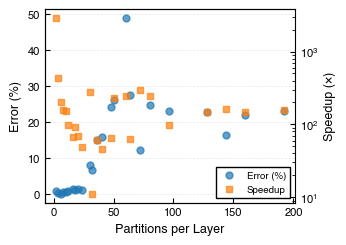


Dataset Statistics:
  Total configurations: 117
  Parts per layer range: 2 - 192
  Error range: 0.00% - 80.34%
  Speedup range: 1.24× - 2903.28×
  Mean error: 13.93%
  Mean speedup: 139.12×


In [10]:
# Generate the plot
fig, ax1, ax2 = plot_noc_comparison_ieee(
    csv_path=data_path_noc_comp,
    figsize=(3.5, 2.5),  # IEEE 2-column width
    save_path='../data/noc_comparison_8x8.png',  # Optional: save as PDF
    dpi=500,
    min_parts_per_layer=None, 
    max_parts_per_layer=None
)

plt.show()

# Print some statistics
df_stats = pd.read_csv(data_path_noc_comp)
print(f"\nDataset Statistics:")
print(f"  Total configurations: {len(df_stats)}")
print(f"  Parts per layer range: {df_stats['parts_per_layer'].min()} - {df_stats['parts_per_layer'].max()}")
print(f"  Error range: {df_stats['percentage_diff'].min():.2f}% - {df_stats['percentage_diff'].max():.2f}%")
print(f"  Speedup range: {df_stats['time_gain'].min():.2f}× - {df_stats['time_gain'].max():.2f}×")
print(f"  Mean error: {df_stats['percentage_diff'].mean():.2f}%")
print(f"  Mean speedup: {df_stats['time_gain'].mean():.2f}×")

In [ ]:
data_path_noc_comp_12x12 = '../data/light_noc_comp_12x12_10October/Noc_comparison_results_ResNet32_early_blocks_12x12_corrected.csv'

Original data: 119 rows
After averaging duplicates and filtering: 26 rows
Figure saved to: ../data/noc_comparison_12x12.png


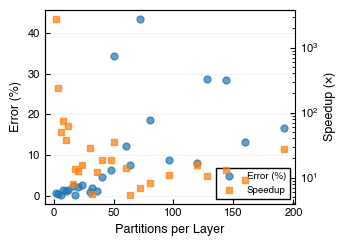


Dataset Statistics:
  Total configurations: 119
  Parts per layer range: 2 - 192
  Error range: 0.19% - 71.11%
  Speedup range: 1.65× - 2766.12×
  Mean error: 7.97%
  Mean speedup: 48.70×


In [12]:
# Generate the plot
fig, ax1, ax2 = plot_noc_comparison_ieee(
    csv_path=data_path_noc_comp_12x12,
    figsize=(3.5, 2.5),  # IEEE 2-column width
    save_path='../data/noc_comparison_12x12.png',  # Optional: save as PDF
    dpi=500
)

plt.show()

# Print some statistics
df_stats = pd.read_csv(data_path_noc_comp_12x12)
print(f"\nDataset Statistics:")
print(f"  Total configurations: {len(df_stats)}")
print(f"  Parts per layer range: {df_stats['parts_per_layer'].min()} - {df_stats['parts_per_layer'].max()}")
print(f"  Error range: {df_stats['percentage_diff'].min():.2f}% - {df_stats['percentage_diff'].max():.2f}%")
print(f"  Speedup range: {df_stats['time_gain'].min():.2f}× - {df_stats['time_gain'].max():.2f}×")
print(f"  Mean error: {df_stats['percentage_diff'].mean():.2f}%")
print(f"  Mean speedup: {df_stats['time_gain'].mean():.2f}×")

Filtering: showing only parts_per_layer <= 100
Original data: 119 rows
After averaging duplicates and filtering: 21 rows
Figure saved to: ../data/100_noc_comparison_12x12.png


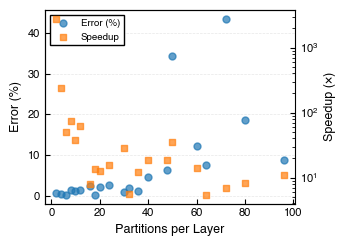

In [48]:
# Generate the plot
fig, ax1, ax2 = plot_noc_comparison_ieee(
    csv_path=data_path_noc_comp_12x12,
    figsize=(3.5, 2.5),  # IEEE 2-column width
    save_path='../data/100_noc_comparison_12x12.png',  # Optional: save as PDF
    dpi=500,
    min_parts_per_layer=None, 
    max_parts_per_layer=100
)

plt.show()

In [17]:
def plot_noc_comparison_latencies_ieee(csv_path, figsize=(3.5, 2.5), save_path=None, dpi=300, min_parts_per_layer=None, max_parts_per_layer=None):
    """
    Create IEEE conference paper style plot (2-column format) for NoC comparison.

    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with NoC comparison results
    figsize : tuple
        Figure size in inches (default: 3.5x2.5 for IEEE 2-column)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    min_parts_per_layer : int, optional
        Minimum number of partitions per layer to include in plot (filters out smaller values)
    max_parts_per_layer : int, optional
        Maximum number of partitions per layer to include (filters out larger values)

    Returns:
    --------
    fig, ax : matplotlib objects
    """

    # Set Helvetica font and IEEE style parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'lines.markersize': 4,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })

    # Read data
    df = pd.read_csv(csv_path)

    # For duplicate parts_per_layer, average the result_booksim and result_analytical
    df_averaged = df.groupby('parts_per_layer').agg({
        'result_booksim': 'mean',
        'result_analytical': 'mean',
        'num_partitions': 'first',  # Keep first value (should be same for duplicates)
        'parts_per_layer': 'first'
    }).reset_index(drop=True)

    # Apply minimum partitions filter if specified
    if min_parts_per_layer is not None:
        df_averaged = df_averaged[df_averaged['parts_per_layer'] >= min_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer >= {min_parts_per_layer}")
    if max_parts_per_layer is not None:
        df_averaged = df_averaged[df_averaged['parts_per_layer'] <= max_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer <= {max_parts_per_layer}")

    # Sort by parts_per_layer for better visualization
    df_sorted = df_averaged.sort_values('parts_per_layer')

    print(f"Original data: {len(df)} rows")
    print(f"After averaging duplicates and filtering: {len(df_sorted)} rows")

    # Create figure with single axis
    fig, ax = plt.subplots(figsize=figsize, dpi=100)

    # Colors
    color1 = "#339feb"  # Blue
    color2 = "#f3933f"  # Orange

    # Plot Booksim latency with scatter and line
    ax.plot(df_sorted['parts_per_layer'], df_sorted['result_booksim'],
            color=color1, marker='o', markersize=4, linewidth=1.5,
            label='Booksim', zorder=3)

    # Plot Lightweight latency with scatter and line
    ax.plot(df_sorted['parts_per_layer'], df_sorted['result_analytical'],
            color=color2, marker='s', markersize=4, linewidth=1.5,
            label='Lightweight', zorder=3)

    # Set labels
    ax.set_xlabel('Partitions per Layer', fontweight='normal')
    ax.set_ylabel('Latency (cycles)', fontweight='normal')
    ax.tick_params(axis='y', direction='in')
    ax.tick_params(axis='x', direction='in')

    # Add horizontal grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)

    # Make top and right spines visible
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

    # Remove ticks from top and right
    ax.tick_params(top=False, right=False)

    # Add legend - FULLY OPAQUE
    ax.legend(loc='best', frameon=True, framealpha=1.0, edgecolor='black',
              fancybox=False, facecolor='white')

    # Tight layout
    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")

    return fig, ax

Filtering: showing only parts_per_layer >= 0
Original data: 117 rows
After averaging duplicates and filtering: 25 rows
Figure saved to: ../data/noc_comparison_latencies_8x8.png


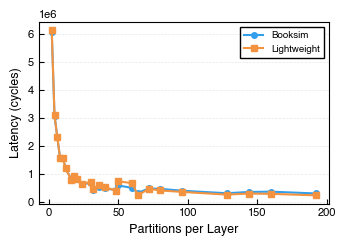

In [64]:
# Generate the plot
fig, ax1 = plot_noc_comparison_latencies_ieee(
    csv_path=data_path_noc_comp,
    figsize=(3.5, 2.5),  # IEEE 2-column width
    save_path='../data/noc_comparison_latencies_8x8.png',
    dpi=500,
    min_parts_per_layer=0
)
plt.show()

Filtering: showing only parts_per_layer >= 40
Original data: 117 rows
After averaging duplicates and filtering: 12 rows
Figure saved to: ../data/noc_comparison_latencies_near_cong_8x8.png


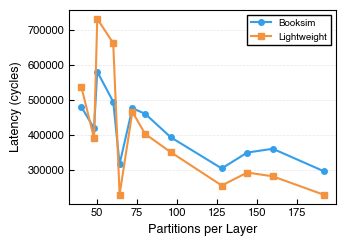

In [65]:
# Generate the plot
fig, ax1 = plot_noc_comparison_latencies_ieee(
    csv_path=data_path_noc_comp,
    figsize=(3.5, 2.5),  # IEEE 2-column width
    save_path='../data/noc_comparison_latencies_near_cong_8x8.png',
    dpi=500,
    min_parts_per_layer=40
)
plt.show()

Filtering: showing only parts_per_layer >= 0
Original data: 119 rows
After averaging duplicates and filtering: 26 rows
Figure saved to: ../data/noc_comparison_latencies_12x12.png


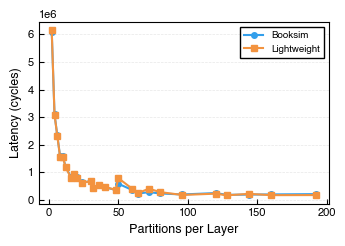

In [66]:
# Generate the plot
fig, ax1 = plot_noc_comparison_latencies_ieee(
    csv_path=data_path_noc_comp_12x12,
    figsize=(3.5, 2.5),  # IEEE 2-column width
    save_path='../data/noc_comparison_latencies_12x12.png',
    dpi=500,
    min_parts_per_layer=0  # Filter out small partitions for clarity
)
plt.show()

Filtering: showing only parts_per_layer >= 40
Original data: 119 rows
After averaging duplicates and filtering: 13 rows
Figure saved to: ../data/noc_comparison_latencies_near_cong_12x12.png


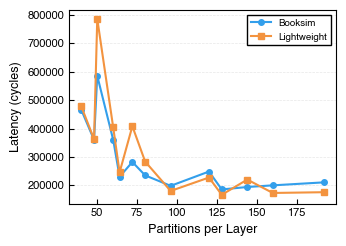

In [67]:
# Generate the plot
fig, ax1 = plot_noc_comparison_latencies_ieee(
    csv_path=data_path_noc_comp_12x12,
    figsize=(3.5, 2.5),  # IEEE 2-column width
    save_path='../data/noc_comparison_latencies_near_cong_12x12.png',
    dpi=500,
    min_parts_per_layer=40  # Filter out small partitions for clarity
)
plt.show()

Filtering: showing only parts_per_layer >= 0
Filtering: showing only parts_per_layer <= 100
Original data: 119 rows
After averaging duplicates and filtering: 21 rows
Figure saved to: ../data/100_noc_comparison_latencies_12x12.png


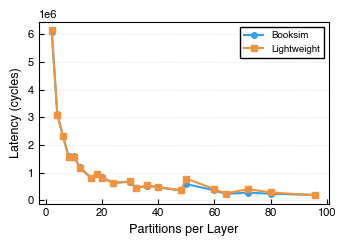

In [18]:
# Generate the plot
fig, ax1 = plot_noc_comparison_latencies_ieee(
    csv_path=data_path_noc_comp_12x12,
    figsize=(3.5, 2.5),  # IEEE 2-column width
    save_path='../data/100_noc_comparison_latencies_12x12.png',
    dpi=500,
    min_parts_per_layer=0, 
    max_parts_per_layer=100
)
plt.show()

### Latency and Energy breakdown plots

In [44]:
def plot_latency_breakdown_ieee(csv_path, figsize=(5.0, 2.5), save_path=None, dpi=300, min_parts_per_layer=False, max_parts_per_layer=False, take_avg=False):
    """
    Create IEEE conference paper style bar plot for latency breakdown.
    
    Shows overall latency as full bars with data flow cycles overlaid on top
    to visualize the proportion of time spent on data communication.
    Note: comp_cycles and data_flow_cycles overlap, so they don't sum to overall_latency_cycles.
     
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with latency/energy results
    figsize : tuple
        Figure size in inches (default: 5.0x2.5 for wider plot)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    min_parts_per_layer : int, optional
        Minimum number of partitions per layer to include in plot (filters out smaller values)
    
    Returns:
    --------
    fig, ax : matplotlib objects
    """
    
    # Set Helvetica font and IEEE style parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })
    
    # Read data
    df = pd.read_csv(csv_path)
    
    if take_avg:
        # Average duplicate parts_per_layer entries - specify which columns to average
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        # Remove parts_per_layer from aggregation since we're grouping by it
        agg_cols = [col for col in numeric_cols if col != 'parts_per_layer']
        
        # Create aggregation dict: mean for numeric columns
        agg_dict = {col: 'mean' for col in agg_cols}
        
        df_filtered = df.groupby('parts_per_layer').agg(agg_dict).reset_index()
    else:
        # For duplicate parts_per_layer, keep only the one with smallest overall_latency_cycles
        df_filtered = df.loc[df.groupby('parts_per_layer')['overall_latency_cycles'].idxmin()]
    
    # Apply minimum partitions filter if specified
    if min_parts_per_layer is not None:
        df_filtered = df_filtered[df_filtered['parts_per_layer'] >= min_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer >= {min_parts_per_layer}")
    if max_parts_per_layer is not None:
        df_filtered = df_filtered[df_filtered['parts_per_layer'] <= max_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer <= {max_parts_per_layer}")
    
    # Sort by parts_per_layer
    df_sorted = df_filtered.sort_values('parts_per_layer')
    
    print(f"Original data: {len(df)} rows")
    print(f"After filtering duplicates and applying min filter: {len(df_sorted)} rows")
    
    # Calculate data flow percentage
    df_sorted = df_sorted.copy()
    df_sorted['data_flow_percentage'] = (df_sorted['data_flow_cycles'] / 
                                         df_sorted['overall_latency_cycles'] * 100)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    
    x_positions = range(len(df_sorted))
    bar_width = 0.8
    
    # Colors
    color_overall = "#F76D55"  # Red for overall latency
    color_dataflow =  "#4A83EC" # Blue for data flow overlay
    
    # Plot overall latency as base bars
    bars1 = ax.bar(x_positions, df_sorted['overall_latency_cycles'], 
                   width=bar_width,
                   color=color_overall, label='Overall Latency', 
                   edgecolor='black', linewidth=0.5, zorder=2)
    
    # Overlay data flow cycles on top (starting from bottom)
    bars2 = ax.bar(x_positions, df_sorted['data_flow_cycles'], 
                   width=bar_width,
                   color=color_dataflow, label='Data Flow', 
                   edgecolor='black', linewidth=0.5, zorder=3,
                   alpha=0.85)  # Slight transparency to show it's an overlay
    
    # Set labels and formatting
    ax.set_xlabel('Partitions per Layer', fontweight='normal')
    ax.set_ylabel('Latency (cycles)', fontweight='normal')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(df_sorted['parts_per_layer'].astype(int), rotation=45)
    
    # Add horizontal grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
    ax.set_axisbelow(True)
    
    # Ticks inside
    ax.tick_params(axis='both', direction='in')
    
    # Make top spine visible without ticks
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.tick_params(top=False, right=False)
    
    # Add legend - fully opaque
    ax.legend(loc='best', frameon=True, framealpha=1.0, 
             edgecolor='black', fancybox=False, facecolor='white')
    
    # Tight layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    # Print statistics
    print(f"\nLatency Statistics:")
    print(f"  Min overall latency: {df_sorted['overall_latency_cycles'].min():.0f} cycles")
    print(f"  Max overall latency: {df_sorted['overall_latency_cycles'].max():.0f} cycles")
    print(f"  Min data flow %: {df_sorted['data_flow_percentage'].min():.1f}%")
    print(f"  Max data flow %: {df_sorted['data_flow_percentage'].max():.1f}%")
    print(f"  Mean data flow %: {df_sorted['data_flow_percentage'].mean():.1f}%")
    print(f"\nData flow percentage trend (showing increasing communication overhead):")
    for idx, row in df_sorted.iterrows():
        print(f"  {int(row['parts_per_layer'])} parts/layer: {row['data_flow_percentage']:.1f}% data flow")
    
    return fig, ax

In [ ]:
# Import plotting functions from plotting_utils
from plotting_utils import (
    plot_latency_breakdown_new_3_bars,
    plot_latency_breakdown_with_error,
    plot_latency_breakdown_with_error_from_two_files_with_broken_axis
)

In [16]:
data_energy = '../data/light_noc_comp_8x8_10October/Latency_energy_results_ResNet32_early_blocks_8x8.csv'
data_energy_12x12 = '../data/light_noc_comp_12x12_10October/Latency_energy_results_ResNet32_early_blocks_12x12.csv'

Filtering: showing only parts_per_layer >= 10
Filtering: showing only parts_per_layer <= 200
Original data: 117 rows
After filtering duplicates and applying min filter: 21 rows
Figure saved to: ../data/test.png

Latency Statistics:
  Min overall latency: 248549 cycles
  Max overall latency: 1554909 cycles
  Min data flow %: 1.7%
  Max data flow %: 68.6%
  Mean data flow %: 27.2%

Data flow percentage trend (showing increasing communication overhead):
  10 parts/layer: 6.7% data flow
  12 parts/layer: 5.4% data flow
  16 parts/layer: 1.7% data flow
  18 parts/layer: 21.8% data flow
  20 parts/layer: 9.2% data flow
  24 parts/layer: 6.3% data flow
  30 parts/layer: 36.6% data flow
  32 parts/layer: 3.2% data flow
  36 parts/layer: 28.0% data flow
  40 parts/layer: 15.7% data flow
  48 parts/layer: 8.1% data flow
  50 parts/layer: 68.6% data flow
  60 parts/layer: 47.5% data flow
  64 parts/layer: 5.2% data flow
  72 parts/layer: 59.6% data flow
  80 parts/layer: 62.3% data flow
  96 part

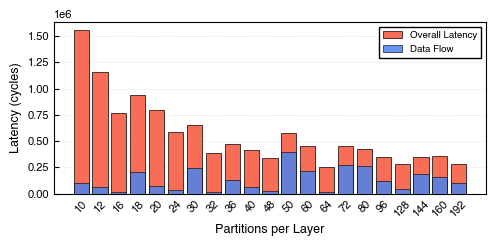

In [7]:
# Generate the latency breakdown bar plot
fig, ax = plot_latency_breakdown_ieee(
    csv_path=data_energy,
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/test.png',
    dpi=800,
    min_parts_per_layer=10,  # Only show results for 8+ partitions per layer
    max_parts_per_layer=200,
    take_avg=False  # Take the best (minimum latency) for duplicates
)

plt.show()

Filtering: showing only parts_per_layer >= 10
Filtering: showing only parts_per_layer <= 200
Original data: 117 rows
After filtering duplicates and applying min filter: 21 rows
Figure saved to: ../data/avg_latency_breakdown_8x8.png

Latency Statistics:
  Min overall latency: 295544 cycles
  Max overall latency: 1576832 cycles
  Min data flow %: 6.9%
  Max data flow %: 68.6%
  Mean data flow %: 32.4%

Data flow percentage trend (showing increasing communication overhead):
  10 parts/layer: 6.9% data flow
  12 parts/layer: 8.9% data flow
  16 parts/layer: 6.9% data flow
  18 parts/layer: 21.8% data flow
  20 parts/layer: 15.6% data flow
  24 parts/layer: 18.4% data flow
  30 parts/layer: 36.3% data flow
  32 parts/layer: 12.3% data flow
  36 parts/layer: 47.9% data flow
  40 parts/layer: 37.9% data flow
  48 parts/layer: 29.6% data flow
  50 parts/layer: 68.6% data flow
  60 parts/layer: 63.2% data flow
  64 parts/layer: 14.7% data flow
  72 parts/layer: 50.3% data flow
  80 parts/layer:

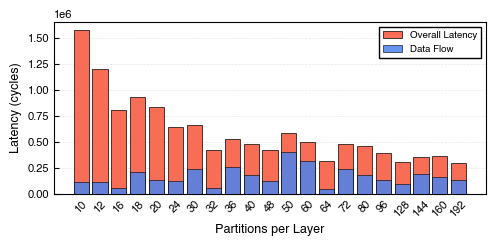

In [31]:
# Generate the latency breakdown bar plot
fig, ax = plot_latency_breakdown_ieee(
    csv_path=data_energy,
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/avg_latency_breakdown_8x8.png',
    dpi=800,
    min_parts_per_layer=10,  # Only show results for 8+ partitions per layer
    max_parts_per_layer=200,
    take_avg=True  # Take the average for duplicates
)

plt.show()

Filtering: showing only parts_per_layer >= 10
Filtering: showing only parts_per_layer <= 200
Original data: 122 rows
After filtering duplicates and applying min filter: 23 rows
Figure saved to: ../data/latency_breakdown_12x12.png

Latency Statistics:
  Min overall latency: 160826 cycles
  Max overall latency: 1559992 cycles
  Min data flow %: 3.3%
  Max data flow %: 87.9%
  Mean data flow %: 31.6%

Data flow percentage trend (showing increasing communication overhead):
  10 parts/layer: 6.8% data flow
  12 parts/layer: 3.3% data flow
  16 parts/layer: 3.7% data flow
  18 parts/layer: 25.3% data flow
  20 parts/layer: 10.8% data flow
  24 parts/layer: 5.8% data flow
  30 parts/layer: 43.6% data flow
  32 parts/layer: 5.6% data flow
  36 parts/layer: 26.8% data flow
  40 parts/layer: 13.3% data flow
  48 parts/layer: 9.7% data flow
  50 parts/layer: 68.4% data flow
  60 parts/layer: 50.3% data flow
  64 parts/layer: 11.2% data flow
  72 parts/layer: 39.9% data flow
  80 parts/layer: 17.5

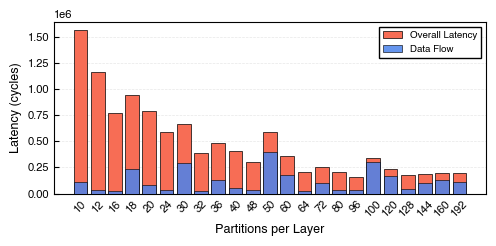

In [32]:
# Generate the latency breakdown bar plot
fig, ax = plot_latency_breakdown_ieee(
    csv_path=data_energy_12x12,
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/latency_breakdown_12x12.png',
    dpi=800,
    min_parts_per_layer=10,  # Only show results for 8+ partitions per layer
    max_parts_per_layer=200,
    take_avg=False  # Take the average for duplicates

)

plt.show()

Filtering: showing only parts_per_layer >= 10
Filtering: showing only parts_per_layer <= 100
Original data: 122 rows
After filtering duplicates and applying min filter: 18 rows
Figure saved to: ../data/avg_latency_breakdown_12x12.png

Latency Statistics:
  Min overall latency: 209188 cycles
  Max overall latency: 1585071 cycles
  Min data flow %: 7.2%
  Max data flow %: 87.9%
  Mean data flow %: 35.9%

Data flow percentage trend (showing increasing communication overhead):
  10 parts/layer: 7.2% data flow
  12 parts/layer: 7.5% data flow
  16 parts/layer: 10.0% data flow
  18 parts/layer: 25.3% data flow
  20 parts/layer: 16.5% data flow
  24 parts/layer: 17.7% data flow
  30 parts/layer: 42.9% data flow
  32 parts/layer: 15.9% data flow
  36 parts/layer: 50.0% data flow
  40 parts/layer: 34.7% data flow
  48 parts/layer: 31.7% data flow
  50 parts/layer: 68.4% data flow
  60 parts/layer: 61.0% data flow
  64 parts/layer: 22.3% data flow
  72 parts/layer: 58.2% data flow
  80 parts/lay

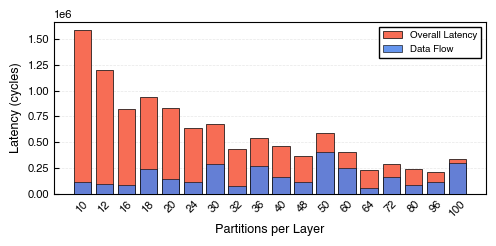

In [ ]:
# Generate the latency breakdown bar plot
fig, ax = plot_latency_breakdown_ieee(
    csv_path=data_energy_12x12,
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/avg_latency_breakdown_12x12.png',
    dpi=800,
    min_parts_per_layer=10,  # Only show results for 8+ partitions per layer
    max_parts_per_layer=200,
    take_avg=True  # Take the average for duplicates
)

plt.show()

Filtering: showing only parts_per_layer >= 10
Filtering: showing only parts_per_layer <= 100
Original data: 122 rows
After filtering duplicates and applying min filter: 18 rows
Figure saved to: ../data/100_latency_breakdown_12x12.png

Latency Statistics:
  Min overall latency: 209188 cycles
  Max overall latency: 1585071 cycles
  Min data flow %: 7.2%
  Max data flow %: 87.9%
  Mean data flow %: 35.9%

Data flow percentage trend (showing increasing communication overhead):
  10 parts/layer: 7.2% data flow
  12 parts/layer: 7.5% data flow
  16 parts/layer: 10.0% data flow
  18 parts/layer: 25.3% data flow
  20 parts/layer: 16.5% data flow
  24 parts/layer: 17.7% data flow
  30 parts/layer: 42.9% data flow
  32 parts/layer: 15.9% data flow
  36 parts/layer: 50.0% data flow
  40 parts/layer: 34.7% data flow
  48 parts/layer: 31.7% data flow
  50 parts/layer: 68.4% data flow
  60 parts/layer: 61.0% data flow
  64 parts/layer: 22.3% data flow
  72 parts/layer: 58.2% data flow
  80 parts/lay

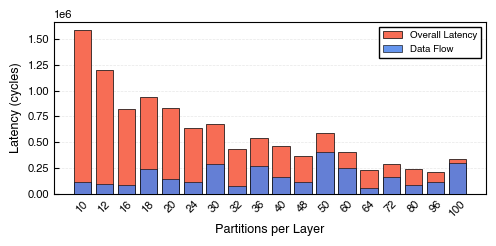

In [34]:
# Generate the latency breakdown bar plot
fig, ax = plot_latency_breakdown_ieee(
    csv_path=data_energy_12x12,
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/100_latency_breakdown_12x12.png',
    dpi=800,
    min_parts_per_layer=10,  # Only show results for 8+ partitions per layer
    max_parts_per_layer=100,
    take_avg=True  # Take the average for duplicates
)

plt.show()

### Here RESNET_SMALL model for fixed flops, sizes and num_partitions 12x12 torus

In [175]:
data_noc_comp_fixed_num_parts = "../data/noc_comp_flops_sizes_29Oct/fixed_partitions_noc_comparison_ResNet_block_smaller.csv"
data_noc_comp_fixed_flops = "../data/noc_comp_flops_sizes_29Oct/flops_noc_comparison_ResNet_block_smaller.csv"
data_noc_comp_fixed_sizes = "../data/noc_comp_flops_sizes_29Oct/sizes_noc_comparison_ResNet_block_smaller.csv"

data_energy_fixed_num_parts = "../data/noc_comp_flops_sizes_29Oct/fixed_partitions_latency_energy_ResNet_block_smaller.csv"
data_energy_fixed_flops = "../data/noc_comp_flops_sizes_29Oct/flops_latency_energy_ResNet_block_smaller.csv"
data_energy_fixed_sizes = "../data/noc_comp_flops_sizes_29Oct/sizes_latency_energy_ResNet_block_smaller.csv"

Original data: 278 rows
Filtering: showing only parts_per_layer >= 10
Filtering: showing only parts_per_layer <= 50
After filtering and processing: 22 rows
Figure saved to: ../data/ResNet_s_12x12_fixed_num_partitions.png


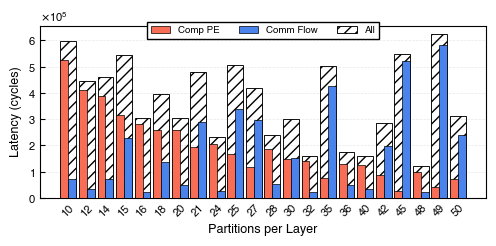

In [192]:
fig, ax = plot_latency_breakdown_new_3_bars(    
    csv_path=data_energy_fixed_num_parts,
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/ResNet_s_12x12_fixed_num_partitions.png',
    dpi=800,
    min_x_value=10,  # Only show results for 0+ partitions per layer
    max_x_value=50,
    take_avg=False,  # Take the best (minimum latency) for duplicates
    x_flops=False,
    x_sizes=False,
    show_legend=True,
    y_scientific=True,
    y_max=None
)

plt.show()

Loaded 278 rows from latency CSV
Loaded 278 rows from error CSV
Merging on: parts_per_layer
After merge: 52 rows
Filtering: showing only parts_per_layer >= 10
Filtering: showing only parts_per_layer <= 50
After filter: 22 configurations
Saved → ../data/ResNet_s_12x12_error_fixed_num_partitions.png


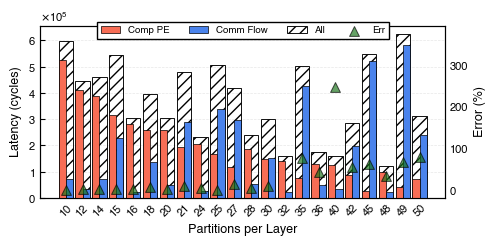

In [177]:
fig, ax1, ax2 = plot_latency_breakdown_with_error(    
    csv_path1=data_energy_fixed_num_parts, #energy
    csv_path2=data_noc_comp_fixed_num_parts, #noc
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/ResNet_s_12x12_error_fixed_num_partitions.png',
    dpi=800,
    min_x_value=10,  # Only show results for 0+ partitions per layer
    max_x_value=50,
    take_avg=False,  # Take the best (minimum latency) for duplicates
    x_flops=False,
    x_sizes=False,
    show_legend=True,
    y_scientific=True,
    y_max=None
)

plt.show()

Original data: 30 rows
After filtering and processing: 30 rows
Figure saved to: ../data/ResNet_s_12x12_fixed_flops.png


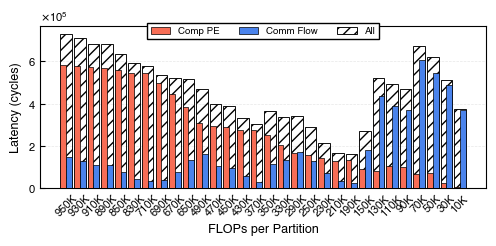

In [178]:
fig, ax = plot_latency_breakdown_new_3_bars(    
    csv_path=data_energy_fixed_flops,
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/ResNet_s_12x12_fixed_flops.png',
    dpi=800,
    min_x_value=None,  # Only show results for 0+ partitions per layer
    max_x_value=None,
    take_avg=False,  # Take the best (minimum latency) for duplicates
    x_flops=True,
    x_sizes=False,
    x_descending=True,
    show_legend=True,
    y_scientific=True,
    y_max=None
)

plt.show()

Loaded 30 rows from latency CSV
Loaded 30 rows from error CSV
Merging on: ['parts_per_layer', 'target_value']
After merge: 30 rows
After filter: 30 configurations
Saved → ../data/ResNet_s_12x12_error_flops.png


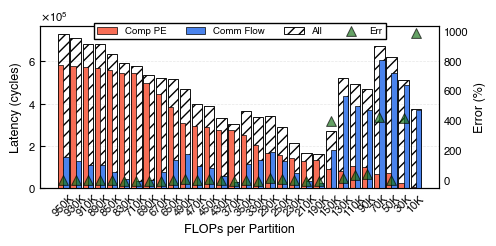

In [179]:
fig, ax1, ax2 = plot_latency_breakdown_with_error(    
    csv_path1=data_energy_fixed_flops, #energy
    csv_path2=data_noc_comp_fixed_flops, #noc
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/ResNet_s_12x12_error_flops.png',
    dpi=800,
    min_x_value=None,  # Only show results for 0+ partitions per layer
    max_x_value=None,
    take_avg=False,  # Take the best (minimum latency) for duplicates
    x_flops=True,
    x_sizes=False,
    x_descending=True,
    show_legend=True,
    y_scientific=True,
    y_max=None
)

plt.show()

Original data: 29 rows
After filtering and processing: 29 rows
Figure saved to: ../data/ResNet_s_12x12_fixed_sizes.png


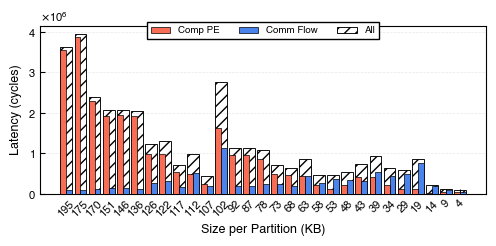

In [180]:
fig, ax = plot_latency_breakdown_new_3_bars(    
    csv_path=data_energy_fixed_sizes,
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/ResNet_s_12x12_fixed_sizes.png',
    dpi=800,
    min_x_value=None,  # Only show results for 0+ partitions per layer
    max_x_value=None,
    take_avg=False,  # Take the best (minimum latency) for duplicates
    x_flops=False,
    x_sizes=True,
    x_descending=True,
    show_legend=True,
    y_scientific=True,
    y_max=None
)

plt.show()

Loaded 29 rows from latency CSV
Loaded 29 rows from error CSV
Merging on: ['parts_per_layer', 'target_value']
After merge: 29 rows
After filter: 29 configurations
Saved → ../data/ResNet_s_12x12_error_sizes.png


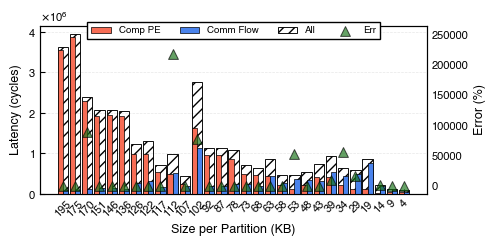

In [181]:
fig, ax, ax2 = plot_latency_breakdown_with_error(    
    csv_path1=data_energy_fixed_sizes,
    csv_path2=data_noc_comp_fixed_sizes,
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/ResNet_s_12x12_error_sizes.png',
    dpi=800,
    min_x_value=None,  # Only show results for 0+ partitions per layer
    max_x_value=None,
    take_avg=False,  # Take the best (minimum latency) for duplicates
    x_flops=False,
    x_sizes=True,
    x_descending=True,
    show_legend=True,
    y_scientific=True,
    y_max=None
)

plt.show()

Loaded 29 rows from latency CSV
Loaded 29 rows from error CSV
Merging on: ['parts_per_layer', 'target_value']
After merge: 29 rows
After filter: 29 configurations
Saved → ../data/ResNet_s_12x12_sizes_with_trend.png


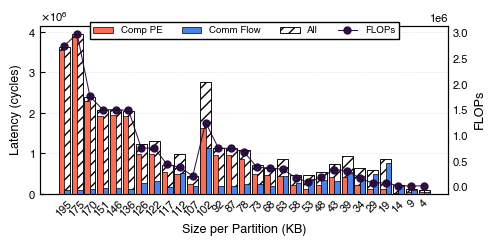

In [182]:
#trend plot for latency breakdown
fig, ax, ax2 = plot_latency_breakdown_with_trend(
    csv_path1=data_energy_fixed_sizes,
    csv_path2=data_noc_comp_fixed_sizes,
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/ResNet_s_12x12_sizes_with_trend.png',
    dpi=800,
    min_x_value=None,  # Only show results for 0+ partitions per layer
    max_x_value=None,
    take_avg=False,  # Take the best (minimum latency) for duplicates
    x_flops=False,
    x_sizes=True,
    x_descending=True,
    show_legend=True,
    y_scientific=True,
    y_max=None)

plt.show()

Loaded 30 rows from latency CSV
Loaded 30 rows from error CSV
Merging on: ['parts_per_layer', 'target_value']
After merge: 30 rows
After filter: 30 configurations
Saved → ../data/ResNet_s_12x12_flops_with_trend.png


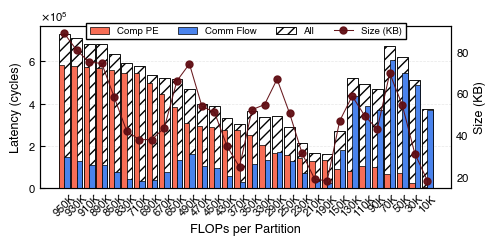

In [183]:
#trend plot for latency breakdown
fig, ax, ax2 = plot_latency_breakdown_with_trend(
    csv_path1=data_energy_fixed_flops,
    csv_path2=data_noc_comp_fixed_flops,
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/ResNet_s_12x12_flops_with_trend.png',
    dpi=800,
    min_x_value=None,  # Only show results for 0+ partitions per layer
    max_x_value=None,
    take_avg=False,  # Take the best (minimum latency) for duplicates
    x_flops=True,
    x_sizes=False,
    x_descending=True,
    show_legend=True,
    y_scientific=True,
    y_max=None)

plt.show()

Loaded 30 rows from latency CSV
Loaded 30 rows from error CSV
Merging on: ['parts_per_layer', 'target_value']
After merge: 30 rows
Filtering: showing only target_value >= 150000
Filtering: showing only target_value <= 250000
After filter: 5 configurations
Saved → ../data/ResNet_s_12x12_flops_with_trend_best.png


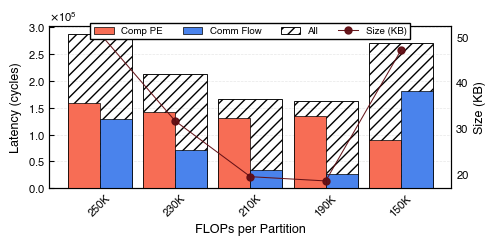

In [187]:
#check for best performing: 

#trend plot for latency breakdown
fig, ax, ax2 = plot_latency_breakdown_with_trend(
    csv_path1=data_energy_fixed_flops,
    csv_path2=data_noc_comp_fixed_flops,
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/ResNet_s_12x12_flops_with_trend_best.png',
    dpi=800,
    min_x_value=150000,  # Only show results for 0+ partitions per layer
    max_x_value=250000,
    take_avg=False,  # Take the best (minimum latency) for duplicates
    x_flops=True,
    x_sizes=False,
    x_descending=True,
    show_legend=True,
    y_scientific=True,
    y_max=None)

plt.show()

Loaded 29 rows from latency CSV
Loaded 29 rows from error CSV
Merging on: ['parts_per_layer', 'target_value']
After merge: 29 rows
Filtering: showing only target_value <= 20000
After filter: 4 configurations
Saved → ../data/ResNet_s_12x12_sizes_with_trend_best.png


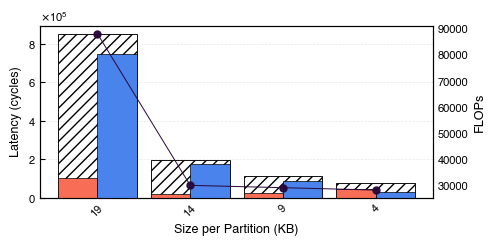

In [190]:
#check for best performing: 

fig, ax, ax2 = plot_latency_breakdown_with_trend(
    csv_path1=data_energy_fixed_sizes,
    csv_path2=data_noc_comp_fixed_sizes,
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/ResNet_s_12x12_sizes_with_trend_best.png',
    dpi=800,
    min_x_value=None,  # Only show results for 0+ partitions per layer
    max_x_value=20000,
    take_avg=False,  # Take the best (minimum latency) for duplicates
    x_flops=False,
    x_sizes=True,
    x_descending=True,
    show_legend=False,
    y_scientific=True,
    y_max=None)

plt.show()

Loaded 29 rows from latency CSV
Loaded 29 rows from error CSV
Merging on: ['parts_per_layer', 'target_value']
After merge: 29 rows
Filtering: showing only target_value <= 20000
After filter: 4 configurations
Saved → ../data/ResNet_s_12x12_sizes_with_trend_best_same_scale.png


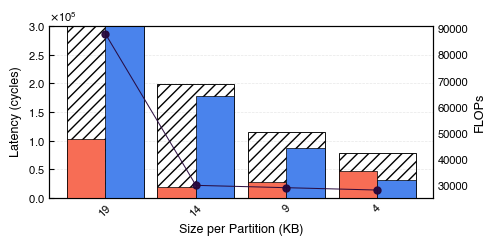

In [191]:
fig, ax, ax2 = plot_latency_breakdown_with_trend(
    csv_path1=data_energy_fixed_sizes,
    csv_path2=data_noc_comp_fixed_sizes,
    figsize=(5.0, 2.5),  # Wider than the previous plot
    save_path='../data/ResNet_s_12x12_sizes_with_trend_best_same_scale.png',
    dpi=800,
    min_x_value=None,  # Only show results for 0+ partitions per layer
    max_x_value=20000,
    take_avg=False,  # Take the best (minimum latency) for duplicates
    x_flops=False,
    x_sizes=True,
    x_descending=True,
    show_legend=False,
    y_scientific=True,
    y_max=300000)

plt.show()

In [142]:
def plot_energy_breakdown_ieee(csv_path, figsize=(5.0, 2.5), save_path=None, dpi=300, min_parts_per_layer=None, max_parts_per_layer=None):
    """
    Create IEEE conference paper style stacked bar plot for energy breakdown.
    
    Shows total energy as stacked bars: PE energy + Data flow energy.
    Note: energy_PEs_uJ + energy_data_flow_uJ = total_energy_uJ
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with latency/energy results
    figsize : tuple
        Figure size in inches (default: 5.0x2.5 for wider plot)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    min_parts_per_layer : int, optional
        Minimum number of partitions per layer to include in plot (filters out smaller values)
    
    Returns:
    --------
    fig, ax : matplotlib objects
    """
    
    # Set Helvetica font and IEEE style parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })
    
    # Read data
    df = pd.read_csv(csv_path)
    
    # For duplicate parts_per_layer, keep only the one with smallest overall_latency_cycles
    df_filtered = df.loc[df.groupby('parts_per_layer')['overall_latency_cycles'].idxmin()]
    
    # Apply minimum partitions filter if specified
    if min_parts_per_layer is not None:
        df_filtered = df_filtered[df_filtered['parts_per_layer'] >= min_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer >= {min_parts_per_layer}")
    if max_parts_per_layer is not None:
        df_filtered = df_filtered[df_filtered['parts_per_layer'] <= max_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer <= {max_parts_per_layer}")
    
    # Sort by parts_per_layer
    df_sorted = df_filtered.sort_values('parts_per_layer')
    
    print(f"Original data: {len(df)} rows")
    print(f"After filtering duplicates and applying min filter: {len(df_sorted)} rows")
    
    # Calculate data flow energy percentage
    df_sorted = df_sorted.copy()
    df_sorted['data_flow_energy_percentage'] = (df_sorted['energy_data_flow_uJ'] / 
                                                 df_sorted['total_energy_uJ'] * 100)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    
    x_positions = range(len(df_sorted))
    bar_width = 0.8
    
    # Colors - different from latency plot
    color_pe = "#46EA8A"  # Green for PE energy
    color_dataflow = '#9B59B6'  # Purple for data flow energy
    
    # Plot stacked bars
    # Bottom part: PE energy
    bars1 = ax.bar(x_positions, df_sorted['energy_PEs_uJ'], 
                   width=bar_width,
                   color=color_pe, label='PE Energy', 
                   edgecolor='black', linewidth=0.5, zorder=2)
    
    # Top part: Data flow energy
    bars2 = ax.bar(x_positions, df_sorted['energy_data_flow_uJ'], 
                   bottom=df_sorted['energy_PEs_uJ'],
                   width=bar_width,
                   color=color_dataflow, label='Data Flow Energy', 
                   edgecolor='black', linewidth=0.5, zorder=2)
    
    # Set labels and formatting
    ax.set_xlabel('Partitions per Layer', fontweight='normal')
    ax.set_ylabel('Energy (µJ)', fontweight='normal')  # microjoules symbol
    ax.set_xticks(x_positions)
    ax.set_xticklabels(df_sorted['parts_per_layer'].astype(int), rotation=45)
    
    # Add horizontal grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
    ax.set_axisbelow(True)
    
    # Ticks inside
    ax.tick_params(axis='both', direction='in')
    
    # Make top spine visible without ticks
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.tick_params(top=False, right=False)
    
    # Add legend - fully opaque
    ax.legend(loc='best', frameon=True, framealpha=1.0, 
             edgecolor='black', fancybox=False, facecolor='white')
    
    # Tight layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    # Print statistics
    print(f"\nEnergy Statistics:")
    print(f"  Min total energy: {df_sorted['total_energy_uJ'].min():.2f} µJ")
    print(f"  Max total energy: {df_sorted['total_energy_uJ'].max():.2f} µJ")
    print(f"  Min data flow energy %: {df_sorted['data_flow_energy_percentage'].min():.1f}%")
    print(f"  Max data flow energy %: {df_sorted['data_flow_energy_percentage'].max():.1f}%")
    print(f"  Mean data flow energy %: {df_sorted['data_flow_energy_percentage'].mean():.1f}%")
    print(f"\nData flow energy percentage trend:")
    for idx, row in df_sorted.iterrows():
        print(f"  {int(row['parts_per_layer'])} parts/layer: {row['data_flow_energy_percentage']:.1f}% data flow energy")
    
    return fig, ax

Filtering: showing only parts_per_layer >= 10
Original data: 117 rows
After filtering duplicates and applying min filter: 21 rows
Figure saved to: ../data/energy_breakdown_8x8.png

Energy Statistics:
  Min total energy: 168.85 µJ
  Max total energy: 2707.40 µJ
  Min data flow energy %: 3.4%
  Max data flow energy %: 57.2%
  Mean data flow energy %: 29.1%

Data flow energy percentage trend:
  10 parts/layer: 18.9% data flow energy
  12 parts/layer: 15.7% data flow energy
  16 parts/layer: 4.3% data flow energy
  18 parts/layer: 34.2% data flow energy
  20 parts/layer: 16.7% data flow energy
  24 parts/layer: 10.8% data flow energy
  30 parts/layer: 44.7% data flow energy
  32 parts/layer: 3.8% data flow energy
  36 parts/layer: 36.7% data flow energy
  40 parts/layer: 19.5% data flow energy
  48 parts/layer: 8.5% data flow energy
  50 parts/layer: 57.2% data flow energy
  60 parts/layer: 43.5% data flow energy
  64 parts/layer: 3.4% data flow energy
  72 parts/layer: 52.1% data flow ene

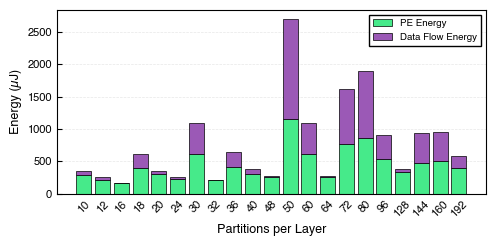

In [36]:
# Generate the energy breakdown bar plot
fig, ax = plot_energy_breakdown_ieee(
    csv_path=data_energy,
    figsize=(5.0, 2.5),  # Same width as latency plot
    save_path='../data/energy_breakdown_8x8.png',
    dpi=800,
    min_parts_per_layer=10  # Only show results for 8+ partitions per layer
)

plt.show()

Filtering: showing only parts_per_layer >= 10
Original data: 122 rows
After filtering duplicates and applying min filter: 23 rows
Figure saved to: ../data/energy_breakdown_12x12.png

Energy Statistics:
  Min total energy: 197.91 µJ
  Max total energy: 4566.19 µJ
  Min data flow energy %: 13.1%
  Max data flow energy %: 74.0%
  Mean data flow energy %: 40.0%

Data flow energy percentage trend:
  10 parts/layer: 32.8% data flow energy
  12 parts/layer: 18.4% data flow energy
  16 parts/layer: 18.4% data flow energy
  18 parts/layer: 52.1% data flow energy
  20 parts/layer: 30.7% data flow energy
  24 parts/layer: 17.2% data flow energy
  30 parts/layer: 57.6% data flow energy
  32 parts/layer: 13.1% data flow energy
  36 parts/layer: 43.6% data flow energy
  40 parts/layer: 25.4% data flow energy
  48 parts/layer: 17.0% data flow energy
  50 parts/layer: 70.8% data flow energy
  60 parts/layer: 62.2% data flow energy
  64 parts/layer: 16.8% data flow energy
  72 parts/layer: 53.1% data f

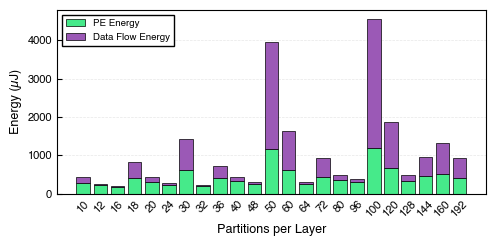

In [122]:
# Generate the energy breakdown bar plot
fig, ax = plot_energy_breakdown_ieee(
    csv_path=data_energy_12x12,
    figsize=(5.0, 2.5),  # Same width as latency plot
    save_path='../data/energy_breakdown_12x12.png',
    dpi=800,
    min_parts_per_layer=10  # Only show results for 8+ partitions per layer
)

plt.show()

Filtering: showing only parts_per_layer >= 10
Filtering: showing only parts_per_layer <= 100
Original data: 122 rows
After filtering duplicates and applying min filter: 18 rows
Figure saved to: ../data/100_energy_breakdown_12x12.png

Energy Statistics:
  Min total energy: 197.91 µJ
  Max total energy: 4566.19 µJ
  Min data flow energy %: 13.1%
  Max data flow energy %: 74.0%
  Mean data flow energy %: 36.4%

Data flow energy percentage trend:
  10 parts/layer: 32.8% data flow energy
  12 parts/layer: 18.4% data flow energy
  16 parts/layer: 18.4% data flow energy
  18 parts/layer: 52.1% data flow energy
  20 parts/layer: 30.7% data flow energy
  24 parts/layer: 17.2% data flow energy
  30 parts/layer: 57.6% data flow energy
  32 parts/layer: 13.1% data flow energy
  36 parts/layer: 43.6% data flow energy
  40 parts/layer: 25.4% data flow energy
  48 parts/layer: 17.0% data flow energy
  50 parts/layer: 70.8% data flow energy
  60 parts/layer: 62.2% data flow energy
  64 parts/layer: 16

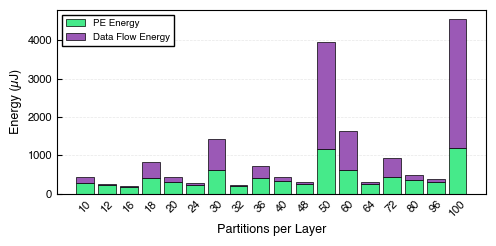

In [37]:
# Generate the energy breakdown bar plot
fig, ax = plot_energy_breakdown_ieee(
    csv_path=data_energy_12x12,
    figsize=(5.0, 2.5),  # Same width as latency plot
    save_path='../data/100_energy_breakdown_12x12.png',
    dpi=800,
    min_parts_per_layer=10,  # Only show results for 8+ partitions per layer
    max_parts_per_layer=100
)

plt.show()

In [38]:
def plot_max_packet_delay_ieee(csv_path, figsize=(5.0, 2.5), save_path=None, dpi=300, min_parts_per_layer=None, max_parts_per_layer=None):
    """
    Create IEEE conference paper style bar plot for maximum packet delay.
    
    Shows how maximum packet delay changes with partitioning strategy.
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with latency/energy results
    figsize : tuple
        Figure size in inches (default: 5.0x2.5 for wider plot)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    min_parts_per_layer : int, optional
        Minimum number of partitions per layer to include in plot (filters out smaller values)
    
    Returns:
    --------
    fig, ax : matplotlib objects
    """
    
    # Set Helvetica font and IEEE style parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })
    
    # Read data
    df = pd.read_csv(csv_path)
    
    # For duplicate parts_per_layer, keep only the one with smallest overall_latency_cycles
    df_filtered = df.loc[df.groupby('parts_per_layer')['overall_latency_cycles'].idxmin()]
    
    # Apply minimum partitions filter if specified
    if min_parts_per_layer is not None:
        df_filtered = df_filtered[df_filtered['parts_per_layer'] >= min_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer >= {min_parts_per_layer}")
    if max_parts_per_layer is not None:
        df_filtered = df_filtered[df_filtered['parts_per_layer'] <= max_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer <= {max_parts_per_layer}")
    
    # Sort by parts_per_layer
    df_sorted = df_filtered.sort_values('parts_per_layer')
    
    print(f"Original data: {len(df)} rows")
    print(f"After filtering duplicates and applying min filter: {len(df_sorted)} rows")
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    
    x_positions = range(len(df_sorted))
    bar_width = 0.8
    
    # Color - using orange for packet delay
    color_delay = "#F49A4B"  # Orange for max packet delay
    
    # Plot bars
    bars = ax.bar(x_positions, df_sorted['max_delay_packets_cycles'], 
                  width=bar_width,
                  color=color_delay, label='Max Packet Delay', 
                  edgecolor='black', linewidth=0.5, zorder=2)
    
    # Set labels and formatting
    ax.set_xlabel('Partitions per Layer', fontweight='normal')
    ax.set_ylabel('Max Packet Delay (cycles)', fontweight='normal')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(df_sorted['parts_per_layer'].astype(int), rotation=45)
    
    # Add horizontal grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
    ax.set_axisbelow(True)
    
    # Ticks inside
    ax.tick_params(axis='both', direction='in')
    
    # Make top spine visible without ticks
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.tick_params(top=False, right=False)
    
    # Add legend - fully opaque
    #ax.legend(loc='best', frameon=True, framealpha=1.0, 
    #         edgecolor='black', fancybox=False, facecolor='white')
    
    # Tight layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    # Print statistics
    print(f"\nMax Packet Delay Statistics:")
    print(f"  Min max delay: {df_sorted['max_delay_packets_cycles'].min():.0f} cycles")
    print(f"  Max max delay: {df_sorted['max_delay_packets_cycles'].max():.0f} cycles")
    print(f"  Mean max delay: {df_sorted['max_delay_packets_cycles'].mean():.0f} cycles")
    print(f"\nMax packet delay trend:")
    for idx, row in df_sorted.iterrows():
        print(f"  {int(row['parts_per_layer'])} parts/layer: {row['max_delay_packets_cycles']:.0f} cycles")
    
    return fig, ax

Filtering: showing only parts_per_layer >= 10
Original data: 117 rows
After filtering duplicates and applying min filter: 21 rows
Figure saved to: ../data/max_packet_delay_8x8.png

Max Packet Delay Statistics:
  Min max delay: 1519 cycles
  Max max delay: 14015 cycles
  Mean max delay: 5012 cycles

Max packet delay trend:
  10 parts/layer: 4757 cycles
  12 parts/layer: 2421 cycles
  16 parts/layer: 1999 cycles
  18 parts/layer: 8518 cycles
  20 parts/layer: 3717 cycles
  24 parts/layer: 1898 cycles
  30 parts/layer: 9019 cycles
  32 parts/layer: 1776 cycles
  36 parts/layer: 5016 cycles
  40 parts/layer: 9088 cycles
  48 parts/layer: 1544 cycles
  50 parts/layer: 14015 cycles
  60 parts/layer: 7660 cycles
  64 parts/layer: 1519 cycles
  72 parts/layer: 5981 cycles
  80 parts/layer: 8637 cycles
  96 parts/layer: 6914 cycles
  128 parts/layer: 2462 cycles
  144 parts/layer: 2956 cycles
  160 parts/layer: 2228 cycles
  192 parts/layer: 3137 cycles


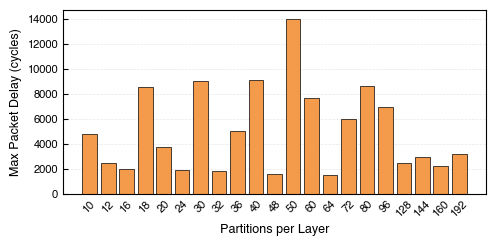

In [124]:
# Generate the max packet delay plot for 8x8 grid
fig, ax = plot_max_packet_delay_ieee(
    csv_path=data_energy,
    figsize=(5.0, 2.5),
    save_path='../data/max_packet_delay_8x8.png',
    dpi=800,
    min_parts_per_layer=10
)

plt.show()

Filtering: showing only parts_per_layer >= 10
Original data: 122 rows
After filtering duplicates and applying min filter: 23 rows
Figure saved to: ../data/max_packet_delay_12x12.png

Max Packet Delay Statistics:
  Min max delay: 1372 cycles
  Max max delay: 23420 cycles
  Mean max delay: 5374 cycles

Max packet delay trend:
  10 parts/layer: 6229 cycles
  12 parts/layer: 2226 cycles
  16 parts/layer: 1372 cycles
  18 parts/layer: 9660 cycles
  20 parts/layer: 4647 cycles
  24 parts/layer: 1855 cycles
  30 parts/layer: 10349 cycles
  32 parts/layer: 1424 cycles
  36 parts/layer: 6099 cycles
  40 parts/layer: 2669 cycles
  48 parts/layer: 2004 cycles
  50 parts/layer: 23420 cycles
  60 parts/layer: 8268 cycles
  64 parts/layer: 1590 cycles
  72 parts/layer: 5144 cycles
  80 parts/layer: 1596 cycles
  96 parts/layer: 5625 cycles
  100 parts/layer: 17438 cycles
  120 parts/layer: 4190 cycles
  128 parts/layer: 1400 cycles
  144 parts/layer: 2205 cycles
  160 parts/layer: 2082 cycles
  192 

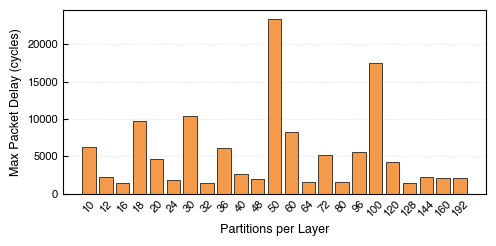

In [125]:
# Generate the max packet delay plot for 12x12 grid
fig, ax = plot_max_packet_delay_ieee(
    csv_path=data_energy_12x12,
    figsize=(5.0, 2.5),
    save_path='../data/max_packet_delay_12x12.png',
    dpi=800,
    min_parts_per_layer=10
)

plt.show()

In [39]:
def plot_avg_packet_size_ieee(csv_path, figsize=(5.0, 2.5), save_path=None, dpi=300, min_parts_per_layer=None, max_parts_per_layer=None):
    """
    Create IEEE conference paper style bar plot for maximum packet delay.
    
    Shows how maximum packet delay changes with partitioning strategy.
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with latency/energy results
    figsize : tuple
        Figure size in inches (default: 5.0x2.5 for wider plot)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    min_parts_per_layer : int, optional
        Minimum number of partitions per layer to include in plot (filters out smaller values)
    
    Returns:
    --------
    fig, ax : matplotlib objects
    """
    
    # Set Helvetica font and IEEE style parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })
    
    # Read data
    df = pd.read_csv(csv_path)
    
    # For duplicate parts_per_layer, keep only the one with smallest overall_latency_cycles
    df_filtered = df.loc[df.groupby('parts_per_layer')['overall_latency_cycles'].idxmin()]
    
    # Apply minimum partitions filter if specified
    if min_parts_per_layer is not None:
        df_filtered = df_filtered[df_filtered['parts_per_layer'] >= min_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer >= {min_parts_per_layer}")
    if max_parts_per_layer is not None:
        df_filtered = df_filtered[df_filtered['parts_per_layer'] <= max_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer <= {max_parts_per_layer}")
    
    # Sort by parts_per_layer
    df_sorted = df_filtered.sort_values('parts_per_layer')
    
    print(f"Original data: {len(df)} rows")
    print(f"After filtering duplicates and applying min filter: {len(df_sorted)} rows")
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    
    x_positions = range(len(df_sorted))
    bar_width = 0.8
    
    # Color - using orange for packet delay
    color_delay = "#6050EE"  # Orange for max packet delay
    
    # Plot bars
    bars = ax.bar(x_positions, df_sorted['avg_packet_size_bytes'], 
                  width=bar_width,
                  color=color_delay, label='Avg Packet Size', 
                  edgecolor='black', linewidth=0.5, zorder=2)
    
    # Set labels and formatting
    ax.set_xlabel('Partitions per Layer', fontweight='normal')
    ax.set_ylabel('Avg Packet Size (B)', fontweight='normal')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(df_sorted['parts_per_layer'].astype(int), rotation=45)
    
    # Add horizontal grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
    ax.set_axisbelow(True)
    
    # Ticks inside
    ax.tick_params(axis='both', direction='in')
    
    # Make top spine visible without ticks
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.tick_params(top=False, right=False)
    
    # Add legend - fully opaque
    #ax.legend(loc='best', frameon=True, framealpha=1.0, 
    #         edgecolor='black', fancybox=False, facecolor='white')
    
    # Tight layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    # Print statistics
    print(f"\nAvg Packet Size Statistics:")
    print(f"  Min max delay: {df_sorted['avg_packet_size_bytes'].min():.0f} Bytes")
    print(f"  Max max delay: {df_sorted['avg_packet_size_bytes'].max():.0f} Bytes")
    print(f"  Mean max delay: {df_sorted['avg_packet_size_bytes'].mean():.0f} Bytes")
    print(f"\nAvg packet size trend:")
    for idx, row in df_sorted.iterrows():
        print(f"  {int(row['parts_per_layer'])} parts/layer: {row['avg_packet_size_bytes']:.0f} bytes")
    
    return fig, ax

Filtering: showing only parts_per_layer >= 10
Original data: 122 rows
After filtering duplicates and applying min filter: 23 rows
Figure saved to: ../data/avg_packet_size_12x12.png

Avg Packet Size Statistics:
  Min max delay: 16 Bytes
  Max max delay: 310 Bytes
  Mean max delay: 82 Bytes

Avg packet size trend:
  10 parts/layer: 310 bytes
  12 parts/layer: 174 bytes
  16 parts/layer: 107 bytes
  18 parts/layer: 239 bytes
  20 parts/layer: 106 bytes
  24 parts/layer: 81 bytes
  30 parts/layer: 158 bytes
  32 parts/layer: 57 bytes
  36 parts/layer: 82 bytes
  40 parts/layer: 51 bytes
  48 parts/layer: 39 bytes
  50 parts/layer: 142 bytes
  60 parts/layer: 56 bytes
  64 parts/layer: 31 bytes
  72 parts/layer: 40 bytes
  80 parts/layer: 26 bytes
  96 parts/layer: 23 bytes
  100 parts/layer: 51 bytes
  120 parts/layer: 28 bytes
  128 parts/layer: 20 bytes
  144 parts/layer: 20 bytes
  160 parts/layer: 18 bytes
  192 parts/layer: 16 bytes


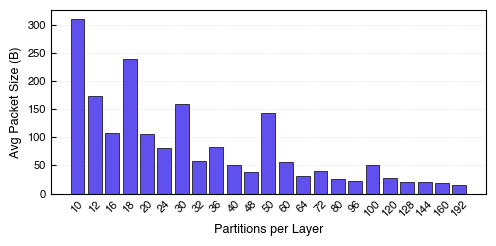

In [127]:
# Generate the max packet delay plot for 12x12 grid
fig, ax = plot_avg_packet_size_ieee(
    csv_path=data_energy_12x12,
    figsize=(5.0, 2.5),
    save_path='../data/avg_packet_size_12x12.png',
    dpi=800,
    min_parts_per_layer=10
)

plt.show()

### Above combined into one plot

In [40]:
def plot_packet_delay_and_size_combined_ieee(csv_path, figsize=(5.0, 2.5), save_path=None, dpi=300, min_parts_per_layer=None, max_parts_per_layer=None):
    """
    Create IEEE conference paper style grouped bar plot combining max packet delay and avg packet size.
    
    Shows max packet delay and average packet size side-by-side with dual y-axes.
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with latency/energy results
    figsize : tuple
        Figure size in inches (default: 5.0x2.5 for wider plot)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    min_parts_per_layer : int, optional
        Minimum number of partitions per layer to include in plot (filters out smaller values)
    
    Returns:
    --------
    fig, ax1, ax2 : matplotlib objects
    """
    
    # Set Helvetica font and IEEE style parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })
    
    # Read data
    df = pd.read_csv(csv_path)
    
    # For duplicate parts_per_layer, keep only the one with smallest overall_latency_cycles
    df_filtered = df.loc[df.groupby('parts_per_layer')['overall_latency_cycles'].idxmin()]
    
    # Apply minimum partitions filter if specified
    if min_parts_per_layer is not None:
        df_filtered = df_filtered[df_filtered['parts_per_layer'] >= min_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer >= {min_parts_per_layer}")
    if max_parts_per_layer is not None:
        df_filtered = df_filtered[df_filtered['parts_per_layer'] <= max_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer <= {max_parts_per_layer}")
    
    # Sort by parts_per_layer
    df_sorted = df_filtered.sort_values('parts_per_layer')
    
    print(f"Original data: {len(df)} rows")
    print(f"After filtering duplicates and applying min filter: {len(df_sorted)} rows")
    
    # Create figure with dual y-axes
    fig, ax1 = plt.subplots(figsize=figsize, dpi=100)
    
    # Set up grouped bars
    x_positions = np.arange(len(df_sorted))
    bar_width = 0.35
    
    # Colors for the two metrics
    color_delay = "#F49A4B"  # Orange for max packet delay
    color_size = "#6050EE"   # Purple for avg packet size
    
    # Plot max packet delay on left y-axis (Y1)
    bars1 = ax1.bar(x_positions - bar_width/2, df_sorted['max_delay_packets_cycles'].values, 
                    width=bar_width,
                    color=color_delay, label='Max Packet Delay', 
                    edgecolor='black', linewidth=0.5, zorder=2)
    
    ax1.set_xlabel('Partitions per Layer', fontweight='normal')
    ax1.set_ylabel('Max Packet Delay (cycles)', fontweight='normal')
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(df_sorted['parts_per_layer'].astype(int).values, rotation=45)
    ax1.tick_params(axis='y', direction='in')
    ax1.tick_params(axis='x', direction='in')
    
    # Add horizontal grid
    ax1.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
    ax1.set_axisbelow(True)
    
    # Create second y-axis for avg packet size (Y2)
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x_positions + bar_width/2, df_sorted['avg_packet_size_bytes'].values, 
                    width=bar_width,
                    color=color_size, label='Average Packet Size', 
                    edgecolor='black', linewidth=0.5, zorder=2)
    
    ax2.set_ylabel('Average Packet Size (B)', fontweight='normal')
    ax2.tick_params(axis='y', direction='in')
    
    # Make top spine visible without ticks
    ax1.spines['top'].set_visible(True)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(True)
    ax2.spines['right'].set_visible(True)
    
    # Remove ticks from top axis
    ax1.tick_params(top=False, labeltop=False)
    ax2.tick_params(top=False, labeltop=False)
    
    # Add combined legend - fully opaque
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, 
              loc='best', frameon=True, framealpha=1.0, 
              edgecolor='black', fancybox=False, facecolor='white')
    
    # Tight layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    # Print statistics
    print(f"\nMax Packet Delay Statistics:")
    print(f"  Min: {df_sorted['max_delay_packets_cycles'].min():.0f} cycles")
    print(f"  Max: {df_sorted['max_delay_packets_cycles'].max():.0f} cycles")
    print(f"  Mean: {df_sorted['max_delay_packets_cycles'].mean():.0f} cycles")
    
    print(f"\nAverage Packet Size Statistics:")
    print(f"  Min: {df_sorted['avg_packet_size_bytes'].min():.0f} B")
    print(f"  Max: {df_sorted['avg_packet_size_bytes'].max():.0f} B")
    print(f"  Mean: {df_sorted['avg_packet_size_bytes'].mean():.0f} B")
    
    print(f"\nCombined trend:")
    for idx, row in df_sorted.iterrows():
        print(f"  {int(row['parts_per_layer'])} parts/layer: "
              f"delay={row['max_delay_packets_cycles']:.0f} cycles, "
              f"size={row['avg_packet_size_bytes']:.0f} B")
    
    return fig, ax1, ax2

Filtering: showing only parts_per_layer >= 10
Original data: 117 rows
After filtering duplicates and applying min filter: 21 rows
Figure saved to: ../data/max_delay_and_avg_packet_size_8x8.png

Max Packet Delay Statistics:
  Min: 1519 cycles
  Max: 14015 cycles
  Mean: 5012 cycles

Average Packet Size Statistics:
  Min: 15 B
  Max: 310 B
  Mean: 87 B

Combined trend:
  10 parts/layer: delay=4757 cycles, size=310 B
  12 parts/layer: delay=2421 cycles, size=174 B
  16 parts/layer: delay=1999 cycles, size=96 B
  18 parts/layer: delay=8518 cycles, size=239 B
  20 parts/layer: delay=3717 cycles, size=106 B
  24 parts/layer: delay=1898 cycles, size=81 B
  30 parts/layer: delay=9019 cycles, size=158 B
  32 parts/layer: delay=1776 cycles, size=52 B
  36 parts/layer: delay=5016 cycles, size=83 B
  40 parts/layer: delay=9088 cycles, size=52 B
  48 parts/layer: delay=1544 cycles, size=38 B
  50 parts/layer: delay=14015 cycles, size=142 B
  60 parts/layer: delay=7660 cycles, size=55 B
  64 parts/l

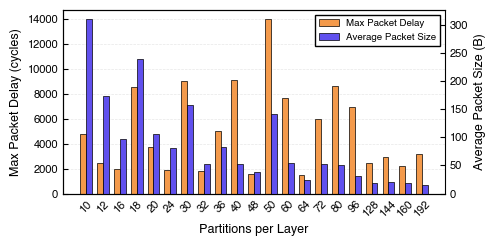

In [41]:
# Generate the max packet delay plot for 12x12 grid
fig = plot_packet_delay_and_size_combined_ieee(
    csv_path=data_energy,
    figsize=(5.0, 2.5),
    save_path='../data/max_delay_and_avg_packet_size_8x8.png',
    dpi=500,
    min_parts_per_layer=10
)

plt.show()

Filtering: showing only parts_per_layer >= 10
Original data: 122 rows
After filtering duplicates and applying min filter: 23 rows
Figure saved to: ../data/max_delay_and_avg_packet_size_12x12.png

Max Packet Delay Statistics:
  Min: 1372 cycles
  Max: 23420 cycles
  Mean: 5374 cycles

Average Packet Size Statistics:
  Min: 16 B
  Max: 310 B
  Mean: 82 B

Combined trend:
  10 parts/layer: delay=6229 cycles, size=310 B
  12 parts/layer: delay=2226 cycles, size=174 B
  16 parts/layer: delay=1372 cycles, size=107 B
  18 parts/layer: delay=9660 cycles, size=239 B
  20 parts/layer: delay=4647 cycles, size=106 B
  24 parts/layer: delay=1855 cycles, size=81 B
  30 parts/layer: delay=10349 cycles, size=158 B
  32 parts/layer: delay=1424 cycles, size=57 B
  36 parts/layer: delay=6099 cycles, size=82 B
  40 parts/layer: delay=2669 cycles, size=51 B
  48 parts/layer: delay=2004 cycles, size=39 B
  50 parts/layer: delay=23420 cycles, size=142 B
  60 parts/layer: delay=8268 cycles, size=56 B
  64 par

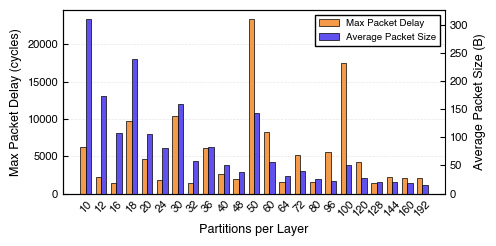

In [42]:
# Generate the max packet delay plot for 12x12 grid
fig = plot_packet_delay_and_size_combined_ieee(
    csv_path=data_energy_12x12,
    figsize=(5.0, 2.5),
    save_path='../data/max_delay_and_avg_packet_size_12x12.png',
    dpi=500,
    min_parts_per_layer=10
)

plt.show()

Filtering: showing only parts_per_layer >= 10
Filtering: showing only parts_per_layer <= 100
Original data: 122 rows
After filtering duplicates and applying min filter: 18 rows
Figure saved to: ../data/100_max_delay_and_avg_packet_size_12x12.png

Max Packet Delay Statistics:
  Min: 1372 cycles
  Max: 23420 cycles
  Mean: 6201 cycles

Average Packet Size Statistics:
  Min: 23 B
  Max: 310 B
  Mean: 99 B

Combined trend:
  10 parts/layer: delay=6229 cycles, size=310 B
  12 parts/layer: delay=2226 cycles, size=174 B
  16 parts/layer: delay=1372 cycles, size=107 B
  18 parts/layer: delay=9660 cycles, size=239 B
  20 parts/layer: delay=4647 cycles, size=106 B
  24 parts/layer: delay=1855 cycles, size=81 B
  30 parts/layer: delay=10349 cycles, size=158 B
  32 parts/layer: delay=1424 cycles, size=57 B
  36 parts/layer: delay=6099 cycles, size=82 B
  40 parts/layer: delay=2669 cycles, size=51 B
  48 parts/layer: delay=2004 cycles, size=39 B
  50 parts/layer: delay=23420 cycles, size=142 B
  60

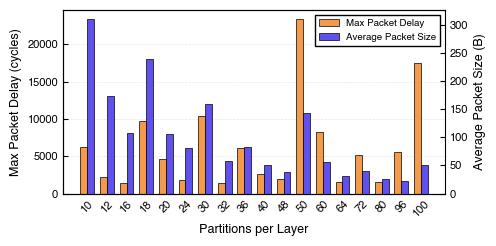

In [43]:
# Generate the max packet delay plot for 12x12 grid
fig = plot_packet_delay_and_size_combined_ieee(
    csv_path=data_energy_12x12,
    figsize=(5.0, 2.5),
    save_path='../data/100_max_delay_and_avg_packet_size_12x12.png',
    dpi=500,
    min_parts_per_layer=10,
    max_parts_per_layer=100
)

plt.show()

In [45]:
def plot_parallel_computations_ieee(csv_path, figsize=(5.0, 2.5), save_path=None, dpi=300, min_parts_per_layer=None, max_parts_per_layer=None, max_parallel_ref=None):
    """
    Create IEEE conference paper style grouped bar plot for parallel computations.
    
    Shows max and average parallel computations as percentages side-by-side for each partition level.
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with latency/energy results
    figsize : tuple
        Figure size in inches (default: 5.0x2.5 for wider plot)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    min_parts_per_layer : int, optional
        Minimum number of partitions per layer to include in plot (filters out smaller values)
    max_parallel_ref : int, optional
        Reference value for 100% parallelism (e.g., 144 PEs = 100%)
        If None, uses the maximum value found in data
    
    Returns:
    --------
    fig, ax : matplotlib objects
    """
    
    # Set Helvetica font and IEEE style parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })
    
    # Read data
    df = pd.read_csv(csv_path)
    
    # For duplicate parts_per_layer, keep only the one with smallest overall_latency_cycles
    df_filtered = df.loc[df.groupby('parts_per_layer')['overall_latency_cycles'].idxmin()]
    
    # Apply minimum partitions filter if specified
    if min_parts_per_layer is not None:
        df_filtered = df_filtered[df_filtered['parts_per_layer'] >= min_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer >= {min_parts_per_layer}")
    if max_parts_per_layer is not None:
        df_filtered = df_filtered[df_filtered['parts_per_layer'] <= max_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer <= {max_parts_per_layer}")
    
    # Sort by parts_per_layer
    df_sorted = df_filtered.sort_values('parts_per_layer')
    
    print(f"Original data: {len(df)} rows")
    print(f"After filtering duplicates and applying min filter: {len(df_sorted)} rows")
    
    # Determine reference value for 100%
    if max_parallel_ref is None:
        max_parallel_ref = df_sorted['max_parallel_computations'].max()
        print(f"Using max value in data as 100% reference: {max_parallel_ref:.1f}")
    else:
        print(f"Using user-specified 100% reference: {max_parallel_ref}")
    
    # Convert to percentages
    df_sorted = df_sorted.copy()
    df_sorted['max_parallel_pct'] = (df_sorted['max_parallel_computations'] / max_parallel_ref) * 100
    df_sorted['avg_parallel_pct'] = (df_sorted['avg_parallel_computations'] / max_parallel_ref) * 100
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    
    # Set up grouped bars
    x_positions = np.arange(len(df_sorted))
    bar_width = 0.35
    
    # Colors for the two bars
    color_max = '#3498DB'  # Blue for max parallel
    color_avg = '#E74C3C'  # Red for avg parallel
    
    # Plot grouped bars with percentages
    bars1 = ax.bar(x_positions - bar_width/2, df_sorted['max_parallel_pct'], 
                   width=bar_width,
                   color=color_max, label='Max', 
                   edgecolor='black', linewidth=0.5, zorder=2)
    
    bars2 = ax.bar(x_positions + bar_width/2, df_sorted['avg_parallel_pct'], 
                   width=bar_width,
                   color=color_avg, label='Average', 
                   edgecolor='black', linewidth=0.5, zorder=2)
    
    # Set labels and formatting
    ax.set_xlabel('Partitions per Layer', fontweight='normal')
    ax.set_ylabel('Parallel Computations (%)', fontweight='normal')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(df_sorted['parts_per_layer'].astype(int), rotation=45)
    
    # Add horizontal grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
    ax.set_axisbelow(True)
    
    # Ticks inside
    ax.tick_params(axis='both', direction='in')
    
    # Make top spine visible without ticks
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.tick_params(top=False, right=False)
    
    # Add legend - fully opaque
    ax.legend(loc='best', frameon=True, framealpha=1.0, 
              edgecolor='black', fancybox=False, facecolor='white')
    
    # Tight layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    # Print statistics
    print(f"\nParallel Computations Statistics (100% = {max_parallel_ref}):")
    print(f"  Max parallel - range: {df_sorted['max_parallel_pct'].min():.1f}% to {df_sorted['max_parallel_pct'].max():.1f}%")
    print(f"  Avg parallel - range: {df_sorted['avg_parallel_pct'].min():.1f}% to {df_sorted['avg_parallel_pct'].max():.1f}%")
    print(f"\nParallel computations trend:")
    for idx, row in df_sorted.iterrows():
        print(f"  {int(row['parts_per_layer'])} parts/layer: max={row['max_parallel_pct']:.1f}% ({row['max_parallel_computations']:.0f}), avg={row['avg_parallel_pct']:.1f}% ({row['avg_parallel_computations']:.1f})")
    
    return fig, ax

Filtering: showing only parts_per_layer >= 10
Original data: 117 rows
After filtering duplicates and applying min filter: 21 rows
Using max value in data as 100% reference: 64.0
Figure saved to: ../data/parallel_computations_8x8.png

Parallel Computations Statistics (100% = 64):
  Max parallel - range: 15.6% to 100.0%
  Avg parallel - range: 12.3% to 76.4%

Parallel computations trend:
  10 parts/layer: max=15.6% (10), avg=12.3% (7.8)
  12 parts/layer: max=18.8% (12), avg=16.4% (10.5)
  16 parts/layer: max=25.0% (16), avg=24.9% (16.0)
  18 parts/layer: max=28.1% (18), avg=21.3% (13.6)
  20 parts/layer: max=31.2% (20), avg=24.2% (15.5)
  24 parts/layer: max=37.5% (24), avg=32.8% (21.0)
  30 parts/layer: max=46.9% (30), avg=30.7% (19.6)
  32 parts/layer: max=50.0% (32), avg=49.3% (31.6)
  36 parts/layer: max=56.2% (36), avg=41.5% (26.6)
  40 parts/layer: max=62.5% (40), avg=47.9% (30.7)
  48 parts/layer: max=75.0% (48), avg=56.0% (35.9)
  50 parts/layer: max=78.1% (50), avg=35.5% (22.7)


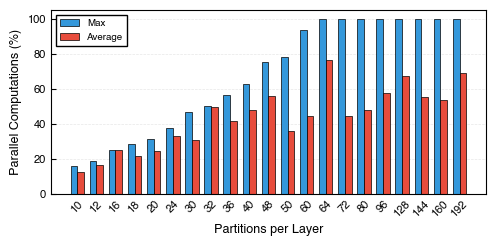

In [132]:
# Generate the parallel computations plot for 8x8 grid
fig, ax = plot_parallel_computations_ieee(
    csv_path=data_energy,
    figsize=(5.0, 2.5),
    save_path='../data/parallel_computations_8x8.png',
    dpi=800,
    min_parts_per_layer=10
)

plt.show()

Filtering: showing only parts_per_layer >= 10
Original data: 122 rows
After filtering duplicates and applying min filter: 23 rows
Using max value in data as 100% reference: 144.0
Figure saved to: ../data/parallel_computations_12x12.png

Parallel Computations Statistics (100% = 144):
  Max parallel - range: 6.9% to 100.0%
  Avg parallel - range: 5.5% to 55.6%

Parallel computations trend:
  10 parts/layer: max=6.9% (10), avg=5.5% (7.9)
  12 parts/layer: max=8.3% (12), avg=7.4% (10.6)
  16 parts/layer: max=11.1% (16), avg=10.9% (15.7)
  18 parts/layer: max=12.5% (18), avg=9.3% (13.5)
  20 parts/layer: max=13.9% (20), avg=10.8% (15.5)
  24 parts/layer: max=16.7% (24), avg=14.5% (21.0)
  30 parts/layer: max=20.8% (30), avg=13.4% (19.3)
  32 parts/layer: max=22.2% (32), avg=21.7% (31.2)
  36 parts/layer: max=25.0% (36), avg=18.6% (26.8)
  40 parts/layer: max=27.8% (40), avg=21.3% (30.7)
  48 parts/layer: max=33.3% (48), avg=28.9% (41.6)
  50 parts/layer: max=34.7% (50), avg=18.1% (26.0)
  6

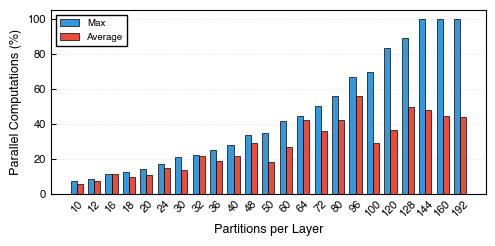

In [133]:
# Generate the parallel computations plot for 12x12 grid
fig, ax = plot_parallel_computations_ieee(
    csv_path=data_energy_12x12,
    figsize=(5.0, 2.5),
    save_path='../data/parallel_computations_12x12.png',
    dpi=800,
    min_parts_per_layer=10
)

plt.show()

Filtering: showing only parts_per_layer >= 10
Filtering: showing only parts_per_layer <= 100
Original data: 122 rows
After filtering duplicates and applying min filter: 18 rows
Using user-specified 100% reference: 144
Figure saved to: ../data/100_parallel_computations_12x12.png

Parallel Computations Statistics (100% = 144):
  Max parallel - range: 6.9% to 69.4%
  Avg parallel - range: 5.5% to 55.6%

Parallel computations trend:
  10 parts/layer: max=6.9% (10), avg=5.5% (7.9)
  12 parts/layer: max=8.3% (12), avg=7.4% (10.6)
  16 parts/layer: max=11.1% (16), avg=10.9% (15.7)
  18 parts/layer: max=12.5% (18), avg=9.3% (13.5)
  20 parts/layer: max=13.9% (20), avg=10.8% (15.5)
  24 parts/layer: max=16.7% (24), avg=14.5% (21.0)
  30 parts/layer: max=20.8% (30), avg=13.4% (19.3)
  32 parts/layer: max=22.2% (32), avg=21.7% (31.2)
  36 parts/layer: max=25.0% (36), avg=18.6% (26.8)
  40 parts/layer: max=27.8% (40), avg=21.3% (30.7)
  48 parts/layer: max=33.3% (48), avg=28.9% (41.6)
  50 parts/l

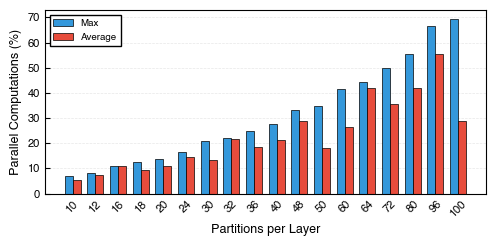

In [46]:
# Generate the parallel computations plot for 12x12 grid
fig, ax = plot_parallel_computations_ieee(
    csv_path=data_energy_12x12,
    figsize=(5.0, 2.5),
    save_path='../data/100_parallel_computations_12x12.png',
    dpi=800,
    min_parts_per_layer=10,
    max_parts_per_layer=100,
    max_parallel_ref=144  # Assuming 12x12 grid with 144 PEs
)

plt.show()

In [134]:
from mpl_toolkits.mplot3d import Axes3D

def plot_latency_breakdown_3d_ieee(csv_path, figsize=(10, 8), save_path=None, dpi=300, 
                                    min_parts_per_layer=None, max_configs=15, 
                                    elev=20, azim=45, select_best=True):
    """
    Create IEEE style 3D bar plot for latency breakdown.
    
    Shows overall latency and data flow cycles as bars in 3D space:
    - X-axis: parts_per_layer (number of partitions)
    - Y-axis: partitioner_config (configuration tuples)
    - Z-axis: Latency (cycles)
    - Bars show overall latency (red) with data flow overlay (blue)
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with latency/energy results
    figsize : tuple
        Figure size in inches (default: 10x8 for 3D plot)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    min_parts_per_layer : int, optional
        Minimum number of partitions per layer to include in plot
    max_configs : int, optional
        Maximum number of partitioner configs to show (default: 15)
    elev : float
        Elevation angle for 3D view (default: 20)
    azim : float
        Azimuth angle for 3D view (default: 45)
    select_best : bool
        If True, select best (lowest latency) configs per parts_per_layer
    
    Returns:
    --------
    fig, ax : matplotlib objects
    """
    
    # Set Helvetica font and IEEE style parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 10,
        'axes.labelsize': 12,
        'axes.titlesize': 12,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 10,
    })
    
    # Read data
    df = pd.read_csv(csv_path)
    
    # Apply minimum partitions filter if specified
    if min_parts_per_layer is not None:
        df = df[df['parts_per_layer'] >= min_parts_per_layer]
        print(f"Filtering: showing only parts_per_layer >= {min_parts_per_layer}")
    
    # Select best configs if requested
    if select_best:
        # For each parts_per_layer, keep only top N configs by lowest latency
        df_filtered = []
        for ppl in df['parts_per_layer'].unique():
            df_ppl = df[df['parts_per_layer'] == ppl].nsmallest(max_configs, 'overall_latency_cycles')
            df_filtered.append(df_ppl)
        df = pd.concat(df_filtered, ignore_index=True)
        print(f"Selected best {max_configs} configs per parts_per_layer")
    else:
        # Limit total configs
        unique_configs = df['partitioner_config'].value_counts().head(max_configs).index
        df = df[df['partitioner_config'].isin(unique_configs)]
    
    # Sort by parts_per_layer and partitioner_config
    df_sorted = df.sort_values(['parts_per_layer', 'partitioner_config'])
    
    print(f"After filtering: {len(df_sorted)} rows")
    
    # Create mappings for axes
    unique_parts = sorted(df_sorted['parts_per_layer'].unique())
    unique_configs = sorted(df_sorted['partitioner_config'].unique())
    
    print(f"Unique parts_per_layer: {len(unique_parts)}")
    print(f"Unique configs: {len(unique_configs)}")
    
    # Create mapping dictionaries
    parts_to_x = {p: i for i, p in enumerate(unique_parts)}
    config_to_y = {c: i for i, c in enumerate(unique_configs)}
    
    # Prepare data for 3D bars
    x_data = np.array([parts_to_x[p] for p in df_sorted['parts_per_layer']])
    y_data = np.array([config_to_y[c] for c in df_sorted['partitioner_config']])
    z_bottom = np.zeros(len(df_sorted))
    
    overall_latency = df_sorted['overall_latency_cycles'].values
    data_flow = df_sorted['data_flow_cycles'].values
    
    # Create 3D figure
    fig = plt.figure(figsize=figsize, dpi=100)
    ax = fig.add_subplot(111, projection='3d')
    
    # Colors
    color_overall = "#F76D55"  # Red for overall latency
    color_dataflow = "#4A83EC"  # Blue for data flow
    
    # Bar dimensions - adjust based on number of items
    dx = 0.6  # Width in x direction
    dy = 0.6  # Width in y direction
    
    # Plot overall latency bars (red) first
    ax.bar3d(x_data, y_data, z_bottom, dx, dy, overall_latency, 
             color=color_overall, alpha=0.85, edgecolor='black', linewidth=0.3,
             label='Overall Latency', shade=True)
    
    # Plot data flow bars (blue) - overlay on top with slight offset for visibility
    ax.bar3d(x_data + 0.05, y_data + 0.05, z_bottom, dx * 0.9, dy * 0.9, data_flow, 
             color=color_dataflow, alpha=0.8, edgecolor='black', linewidth=0.3,
             label='Data Flow', shade=True)
    
    # Set labels with better spacing
    ax.set_xlabel('Partitions per Layer', fontweight='bold', labelpad=15)
    ax.set_ylabel('Partitioner Config', fontweight='bold', labelpad=15)
    ax.set_zlabel('Latency (cycles)', fontweight='bold', labelpad=15)
    
    # Set ticks - show fewer for readability
    x_tick_step = max(1, len(unique_parts) // 10)
    y_tick_step = max(1, len(unique_configs) // 10)
    
    ax.set_xticks(range(0, len(unique_parts), x_tick_step))
    ax.set_xticklabels([str(unique_parts[i]) for i in range(0, len(unique_parts), x_tick_step)])
    
    ax.set_yticks(range(0, len(unique_configs), y_tick_step))
    ax.set_yticklabels([str(unique_configs[i]) for i in range(0, len(unique_configs), y_tick_step)], 
                       fontsize=8)
    
    # Set viewing angle
    ax.view_init(elev=elev, azim=azim)
    
    # Add legend with better positioning
    ax.legend(loc='upper left', frameon=True, framealpha=0.95, 
              edgecolor='black', fancybox=False, facecolor='white')
    
    # Add grid with better visibility
    ax.grid(True, linestyle='--', alpha=0.4, linewidth=0.5)
    
    # Set pane colors for better visibility
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    # Make panes more transparent
    ax.xaxis.pane.set_edgecolor('gray')
    ax.yaxis.pane.set_edgecolor('gray')
    ax.zaxis.pane.set_edgecolor('gray')
    ax.xaxis.pane.set_alpha(0.1)
    ax.yaxis.pane.set_alpha(0.1)
    ax.zaxis.pane.set_alpha(0.1)
    
    # Tight layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    # Print statistics
    print(f"\n3D Plot Statistics:")
    print(f"  Total bars: {len(df_sorted)}")
    print(f"  Min overall latency: {overall_latency.min():.0f} cycles")
    print(f"  Max overall latency: {overall_latency.max():.0f} cycles")
    print(f"  Avg data flow %: {(data_flow / overall_latency * 100).mean():.1f}%")
    
    return fig, ax

Filtering: showing only parts_per_layer >= 10
Selected best 5 configs per parts_per_layer
After filtering: 76 rows
Unique parts_per_layer: 21
Unique configs: 76


/var/folders/fj/pymmx6_53ksdnv6l4vhkxl5r0000gn/T/ipykernel_18371/1720876571.py:161: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Figure saved to: ../data/latency_breakdown_3d_8x8.png

3D Plot Statistics:
  Total bars: 76
  Min overall latency: 248549 cycles
  Max overall latency: 1598754 cycles
  Avg data flow %: 26.6%


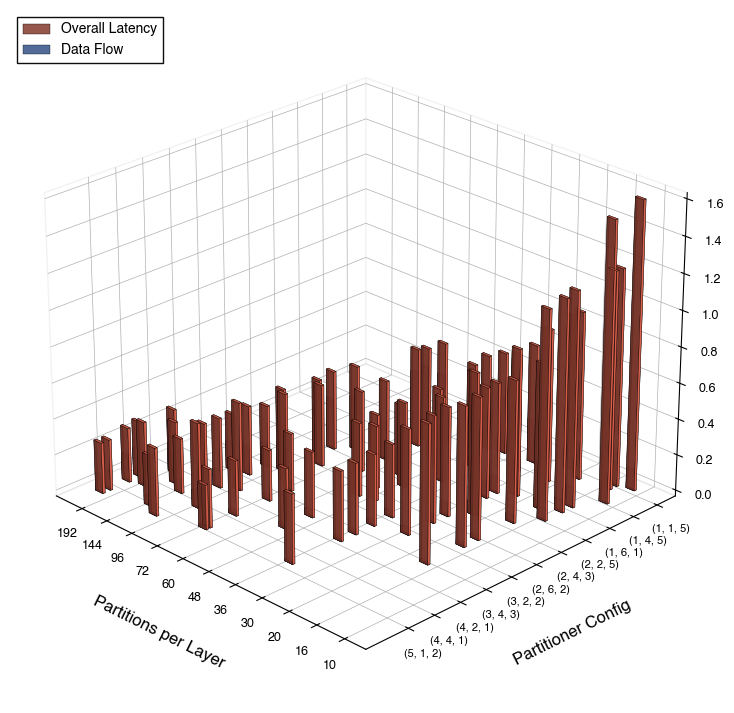

In [95]:
# Generate the 3D latency breakdown plot for 8x8 grid
# This will show best 5 configs per partition level for clarity
fig, ax = plot_latency_breakdown_3d_ieee(
    csv_path=data_energy,
    figsize=(12, 9),
    save_path='../data/latency_breakdown_3d_8x8.png',
    dpi=300,
    min_parts_per_layer=10,  # Filter small partitions
    max_configs=5,  # Show top 5 best configs per parts_per_layer
    elev=25,  # Elevation angle
    azim=135,  # Azimuth angle (view from different direction)
    select_best=True  # Select best performing configs
)

plt.show()